In [ ]:
#https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Settings -> Internet -> Phone Validation required to internet connection

!pip install imutils

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [ ]:
class FashionNet:
	@staticmethod
	def build_category_branch(inputs, numCategories,
		finalAct="softmax", chanDim=-1):
		# utilize a lambda layer to convert the 3 channel input to a
		# grayscale representation
		x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)

		# (CONV => RELU) * 2 => POOL
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# (CONV => RELU) * 2 => POOL
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(128, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# define a branch of output layers for the number of different
		# clothing categories (i.e., shirts, jeans, dresses, etc.)
		x = Flatten()(x)
		x = Dense(256)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numCategories)(x)
		x = Activation(finalAct, name="category_output")(x)

		# return the category prediction sub-network
		return x

	@staticmethod
	def build_color_branch(inputs, numColors, finalAct="softmax",
		chanDim=-1):
		# CONV => RELU => POOL
		x = Conv2D(16, (3, 3), padding="same")(inputs)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)

		# define a branch of output layers for the number of different
		# colors (i.e., red, black, blue, etc.)
		x = Flatten()(x)
		x = Dense(128)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numColors)(x)
		x = Activation(finalAct, name="color_output")(x)

		# return the color prediction sub-network
		return x

	@staticmethod
	def build(width, height, numCategories, numColors,
		finalAct="softmax"):
		# initialize the input shape and channel dimension (this code
		# assumes you are using TensorFlow which utilizes channels
		# last ordering)
		inputShape = (height, width, 3)
		chanDim = -1

		# construct both the "category" and "color" sub-networks
		inputs = Input(shape=inputShape)
		categoryBranch = FashionNet.build_category_branch(inputs,numCategories, finalAct=finalAct, chanDim=chanDim)
		colorBranch = FashionNet.build_color_branch(inputs,numColors, finalAct=finalAct, chanDim=chanDim)

		# create the model using our input (the batch of images) and
		# two separate outputs -- one for the clothing category
		# branch and another for the color branch, respectively
		model = Model(inputs=inputs,outputs=[categoryBranch, colorBranch],name="fashionnet")

		# return the constructed network architecture
		return model

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 20 #64, reduce batch_size for small GPU memory
IMAGE_DIMS = (96, 96, 3)

In [ ]:
# +Add data before loading

!wget -O gdrivedl 'https://f.mjh.nz/gdrivedl'
!ls -l
!pwd

"""
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/1qAkuWIxXwdrUwUfFwUw_jwFSxeca1MRT/view?usp=sharing
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/1XKFjSEQ9yeiUiDQdqlbknHIuKfDXbX2P/view?usp=sharing
!ls -l /kaggle/working
inputdir = "/kaggle/working"
"""

!bash /content/gdrivedl https://drive.google.com/file/d/1qAkuWIxXwdrUwUfFwUw_jwFSxeca1MRT/view?usp=sharing
!bash /content/gdrivedl https://drive.google.com/file/d/1XKFjSEQ9yeiUiDQdqlbknHIuKfDXbX2P/view?usp=sharing
!ls -l /content
inputdir = "/content"

--2020-12-12 22:45:25--  https://f.mjh.nz/gdrivedl
Resolving f.mjh.nz (f.mjh.nz)... 172.67.162.157, 104.28.30.233, 104.28.31.233, ...
Connecting to f.mjh.nz (f.mjh.nz)|172.67.162.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [application/octet-stream]
Saving to: ‘gdrivedl’

gdrivedl            100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-12-12 22:45:25 (24.0 MB/s) - ‘gdrivedl’ saved [1362/1362]

total 525136
-rw-r--r-- 1 root root 537507216 Dec 12 22:43 dataset_multi_output_classification.zip
-rw-r--r-- 1 root root    215802 Dec 12 22:43 examples_multi_output_classification.zip
-rw-r--r-- 1 root root      1362 Jan 29  2019 gdrivedl
drwxr-xr-x 1 root root      4096 Dec  2 22:04 sample_data
/content
File ID: 1qAkuWIxXwdrUwUfFwUw_jwFSxeca1MRT
Downloading: https://docs.google.com/uc?export=download&id=1qAkuWIxXwdrUwUfFwUw_jwFSxeca1MRT > .168.file
Downloading: https://docs.google.com/uc?export=download&id=1qAkuWIxXwdrUwUfFwUw_

In [ ]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
#imagePaths = sorted(list(paths.list_images('dataset_multi_output_classification')))
imagefilename = os.path.join(inputdir, 'dataset_multi_output_classification.zip')
import zipfile
zf = zipfile.ZipFile(imagefilename)
random.seed(42)
imagePaths = zf.namelist()
random.shuffle(imagePaths)

[INFO] loading images...


In [ ]:
# initialize the data, clothing category labels (i.e., shirts, jeans,
# dresses, etc.) along with the color labels (i.e., red, blue, etc.)
data = []
categoryLabels = []
colorLabels = []

In [ ]:
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	#image = cv2.imread(imagePath)
	image = cv2.imdecode(np.frombuffer(zf.read(imagePath), np.uint8), 1)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	# extract the clothing color and category from the path and
	# update the respective lists
	#(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
	(color, cat) = imagePath.split('/')[0].split("_")
	#print(imagePath, color, cat)
	categoryLabels.append(cat)
	colorLabels.append(color)

In [ ]:
print(len(categoryLabels))
print(len(colorLabels))

2525
2525


In [ ]:
# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 2525 images (545.40MB)


In [ ]:
# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

In [ ]:
print(len(categoryLabels))
print(len(colorLabels))

2525
2525


In [ ]:
# binarize both sets of labels
print("[INFO] binarizing labels...")
categoryLB = LabelBinarizer()
colorLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
colorLabels = colorLB.fit_transform(colorLabels)

[INFO] binarizing labels...


In [ ]:
print(len(categoryLabels))
print(len(colorLabels))

2525
2525


In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,trainColorY, testColorY) = split

In [ ]:
# initialize our FashionNet multi-output network
model = FashionNet.build(96, 96,numCategories=len(categoryLB.classes_),numColors=len(colorLB.classes_),finalAct="softmax")

In [ ]:
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {"category_output": "categorical_crossentropy","color_output": "categorical_crossentropy",}
lossWeights = {"category_output": 1.0, "color_output": 1.0}

In [ ]:
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.summary()

Model: "fashionnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96, 96, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         lambda[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           conv2d[0][0]                     
_________________________________________________________________________________________

In [ ]:
# train the network to perform multi-output classification
history = model.fit(trainX,{"category_output": trainCategoryY, "color_output": trainColorY},validation_data=(testX,{"category_output": testCategoryY, "color_output": testColorY}),epochs=EPOCHS,batch_size=BS,verbose=1)

Epoch 1/50
101/101 [==============================] - 2s 20ms/step - loss: 0.9016 - category_output_loss: 0.5961 - color_output_loss: 0.3055 - category_output_accuracy: 0.8228 - color_output_accuracy: 0.8896 - val_loss: 3.8105 - val_category_output_loss: 1.5763 - val_color_output_loss: 2.2343 - val_category_output_accuracy: 0.2871 - val_color_output_accuracy: 0.4733
Epoch 2/50
101/101 [==============================] - 2s 16ms/step - loss: 0.5900 - category_output_loss: 0.4367 - color_output_loss: 0.1533 - category_output_accuracy: 0.8554 - color_output_accuracy: 0.9520 - val_loss: 3.6323 - val_category_output_loss: 1.1389 - val_color_output_loss: 2.4934 - val_category_output_accuracy: 0.6376 - val_color_output_accuracy: 0.6297
Epoch 3/50
101/101 [==============================] - 2s 15ms/step - loss: 0.4091 - category_output_loss: 0.3200 - color_output_loss: 0.0891 - category_output_accuracy: 0.8965 - color_output_accuracy: 0.9713 - val_loss: 4.2009 - val_category_output_loss: 1.5632 

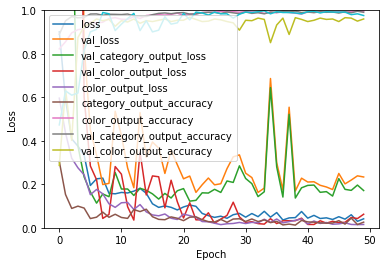

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_category_output_loss'])
plt.plot(history.history['val_color_output_loss'])
plt.plot(history.history['category_output_loss'])
plt.plot(history.history['color_output_loss'])
plt.plot(history.history['category_output_accuracy'])
plt.plot(history.history['color_output_accuracy'])
plt.plot(history.history['val_category_output_accuracy'])
plt.plot(history.history['val_color_output_accuracy'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0., 1.0)
plt.legend(['loss', 'val_loss', 'val_category_output_loss', 'val_color_output_loss', 'color_output_loss', 'category_output_accuracy', 'color_output_accuracy', 'val_category_output_accuracy', 'val_color_output_accuracy' ], loc='upper left')
plt.show()

In [ ]:
import tempfile
TEMPDIR = tempfile.gettempdir()
# save the model to disk
print("[INFO] serializing network...")
model.save(os.path.join(TEMPDIR, "multi_output_classification.h5"))

[INFO] serializing network...


In [ ]:
# save the category binarizer to disk
print("[INFO] serializing category label binarizer...")
f = open(os.path.join(TEMPDIR, "multi_output_classification_categorybin.pkl"), "wb")
f.write(pickle.dumps(categoryLB))
f.close()

[INFO] serializing category label binarizer...


In [ ]:
# save the color binarizer to disk
print("[INFO] serializing color label binarizer...")
f = open(os.path.join(TEMPDIR, "multi_output_classification_colorbin.pkl"), "wb")
f.write(pickle.dumps(colorLB))
f.close()

[INFO] serializing color label binarizer...


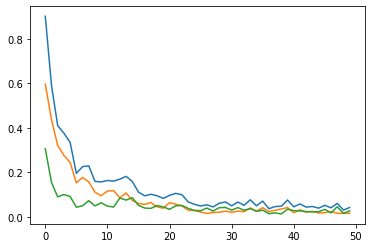

In [ ]:
# plot the total loss, category loss, and color loss
plt.plot(history.history['loss'])
plt.plot(history.history['category_output_loss'])
plt.plot(history.history['color_output_loss'])
plt.style.use("ggplot")

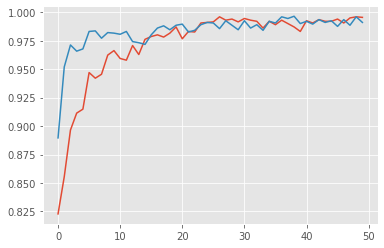

In [ ]:
# create a new figure for the accuracies
plt.plot(history.history['category_output_accuracy'])
plt.plot(history.history['color_output_accuracy'])
plt.style.use("ggplot")

In [ ]:
# load the image
import imutils
import cv2
imagefilename = os.path.join(inputdir, 'examples_multi_output_classification.zip')
import zipfile
zf = zipfile.ZipFile(imagefilename)
#image = cv2.imread(os.path.join('examples_multi_output_classification', 'black_dress.jpg'), cv2.IMREAD_COLOR)
image = cv2.imdecode(np.frombuffer(zf.read('black_dress.jpg'), np.uint8), 1)
output = imutils.resize(image, width=400)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
image.shape

(533, 320, 3)

In [ ]:
# pre-process the image for classification
import cv2
image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA)

In [ ]:
# pre-process the image for classification
image = image.astype("float") / 255.0
image = img_to_array(image)
print(image.shape)
image = np.expand_dims(image, axis=0)# pre-process the image for classification

(96, 96, 3)


In [ ]:
# load the trained convolutional neural network from disk, followed
# by the category and color label binarizers, respectively
from keras.preprocessing.image import img_to_array
from keras.models import load_model
print("[INFO] loading network...")
model = load_model(os.path.join(TEMPDIR, 'multi_output_classification.h5'), custom_objects={"tf": tf})
categoryLB = pickle.loads(open(os.path.join(TEMPDIR, 'multi_output_classification_categorybin.pkl'), "rb").read())
colorLB = pickle.loads(open(os.path.join(TEMPDIR, 'multi_output_classification_colorbin.pkl'), "rb").read())

[INFO] loading network...


In [ ]:
# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
(categoryProba, colorProba) = model.predict(image)

[INFO] classifying image...


In [ ]:
# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

In [ ]:
# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
	categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
	colorProba[0][colorIdx] * 100)
cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
# display the predictions to the terminal as well
print("[INFO] {}".format(categoryText))
print("[INFO] {}".format(colorText))

[INFO] category: dress (99.87%)
[INFO] color: black (87.89%)


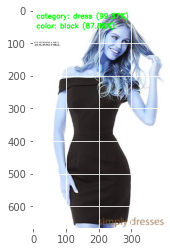

In [ ]:
# show the output image
#cv2.imshow("Output", output)
#cv2.waitKey(0)
plt.imshow(output)